In [1]:
# Cell 0 - imports & config
import os, glob, pathlib, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# reproducibility
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# paths & params
DATASET_DIR = "dataset"   # root folder containing train/, val/, test/ and label_colors.txt
IMG_SIZE = (512, 512)
BATCH_SIZE = 4            # increase if GPU memory allows
AUTOTUNE = tf.data.AUTOTUNE


In [2]:
# Cell 1 - parse label_colors.txt
label_colors_path = os.path.join(DATASET_DIR, "label_colors.txt")
if not os.path.exists(label_colors_path):
    raise FileNotFoundError(f"label_colors.txt not found at {label_colors_path}")

color_to_name = {}
with open(label_colors_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        # expected: R G B name
        r, g, b = map(int, parts[:3])
        name = " ".join(parts[3:])
        color_to_name[(r, g, b)] = name

# Make deterministic ordering: background first if present (common)
# Create class_names list and mapping to indices
ordered_colors = sorted(color_to_name.items(), key=lambda x: (x[1] != "background", x[1]))
class_names = [name for (_, name) in ordered_colors]
color_list = [color for (color, _) in ordered_colors]
class_to_index = {name: idx for idx, name in enumerate(class_names)}
index_to_color = {class_to_index[name]: color for color, name in color_to_name.items() for name in [color_to_name[color]]}

print("Detected color->name mapping:", color_to_name)
print("Class names (index order):", class_names)
print("Class->index:", class_to_index)
print("Index->color (r,g,b):", index_to_color)


Detected color->name mapping: {(0, 0, 0): 'background', (255, 0, 124): 'oil', (255, 204, 51): 'others', (51, 221, 255): 'water'}
Class names (index order): ['background', 'oil', 'others', 'water']
Class->index: {'background': 0, 'oil': 1, 'others': 2, 'water': 3}
Index->color (r,g,b): {0: (0, 0, 0), 1: (255, 0, 124), 2: (255, 204, 51), 3: (51, 221, 255)}


In [3]:
# Cell 2 - collect pairs
def list_pairs(split):
    im_dir = os.path.join(DATASET_DIR, split, "images")
    mask_dir = os.path.join(DATASET_DIR, split, "masks")
    imgs = sorted(glob.glob(os.path.join(im_dir, "*")))
    masks = sorted(glob.glob(os.path.join(mask_dir, "*")))
    if len(imgs) != len(masks):
        raise ValueError(f"Mismatch in {split}: {len(imgs)} images vs {len(masks)} masks")
    return list(zip(imgs, masks))

train_pairs = list_pairs("train")
val_pairs   = list_pairs("val")
test_pairs  = list_pairs("test")

print("Samples - train/val/test:", len(train_pairs), len(val_pairs), len(test_pairs))
# show first pair
if len(train_pairs)>0:
    print("Example pair:", train_pairs[0][0], train_pairs[0][1])


Samples - train/val/test: 811 203 254
Example pair: dataset\train\images\Oil (1).jpg dataset\train\masks\Oil (1).png


In [4]:
# Cell 3 - build TF constants for color->index mapping
# Build ordered list of colors matching class_names order
colors_in_order = [None]*len(class_names)
for (r,g,b), name in color_to_name.items():
    idx = class_to_index[name]
    colors_in_order[idx] = (r,g,b)
colors_keys = tf.constant(colors_in_order, dtype=tf.uint8)  # shape (C,3)

def rgb_mask_to_class_ids(mask):
    """
    mask: uint8 tensor shape (H,W,3)
    returns: uint8 tensor shape (H,W) with values in 0..C-1
    """
    mask_flat = tf.reshape(mask, [-1,3])                  # (H*W, 3)
    # broadcast compare: (H*W,1,3) == (1,C,3) -> (H*W,C,3), reduce_all -> (H*W, C)
    eq = tf.reduce_all(tf.equal(mask_flat[:, None, :], colors_keys[None, :, :]), axis=-1)
    # idx where eq is true; we convert boolean matrix to integer indices
    # if no match occurs for a pixel (shouldn't happen), we set 0 (background) - handle with argmax
    class_ids_flat = tf.argmax(tf.cast(eq, tf.int32), axis=-1)
    class_ids = tf.reshape(class_ids_flat, tf.shape(mask)[:2])
    class_ids = tf.cast(class_ids, tf.uint8)
    return class_ids


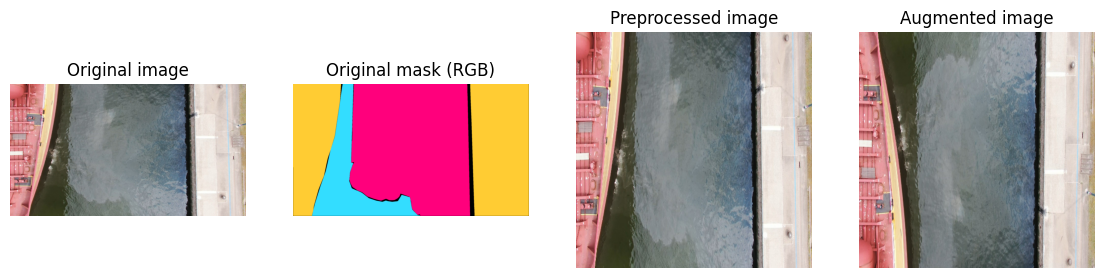

In [5]:
# Cell 4 - visualization helpers (corrected)

def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    return img

def read_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_png(m, channels=3)
    return m

# simple augmentation that can be applied consistently to image & mask
def aug_image_and_mask(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    return img, mask

def color_mask_from_index(mask_index):
    palette = np.array(colors_in_order, dtype=np.uint8)  # Cx3
    mask_index = mask_index.astype(np.int32)
    colored = palette[mask_index]
    return colored

def show_original_mask_preproc_aug(pair):
    img_path, mask_path = pair
    orig_img = read_image(img_path).numpy()
    orig_mask_rgb = read_mask(mask_path).numpy()

    # Preprocess
    img_resized = tf.image.resize(orig_img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR).numpy()
    img_rescaled = (img_resized / 255.0).astype(np.float32)

    mask_resized = tf.image.resize(orig_mask_rgb, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy().astype(np.uint8)
    mask_index = rgb_mask_to_class_ids(mask_resized).numpy()
    mask_colored = color_mask_from_index(mask_index)

    # Augment
    img_aug, mask_aug = aug_image_and_mask(img_resized.astype(np.uint8), mask_resized)
    mask_aug_index = rgb_mask_to_class_ids(mask_aug).numpy()
    mask_aug_colored = color_mask_from_index(mask_aug_index)
    img_aug_rescaled = (img_aug.numpy() / 255.0).astype(np.float32)

    # Plot
    plt.figure(figsize=(14,6))
    plt.subplot(1,4,1); plt.imshow(orig_img); plt.title("Original image"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(orig_mask_rgb); plt.title("Original mask (RGB)"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(img_rescaled); plt.title("Preprocessed image"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(img_aug_rescaled); plt.title("Augmented image"); plt.axis("off")
    plt.show()

# Example usage
if len(train_pairs) > 0:
    sample_pair = random.choice(train_pairs)
    show_original_mask_preproc_aug(sample_pair)


In [6]:
# Cell 5 - binary label encoder

# Find oil class index from label_colors
if "oil" not in class_to_index:
    found = None
    for name in class_to_index:
        if "oil" in name.lower():
            found = name
            break
    if found is None:
        raise ValueError("No 'oil' class found in label_colors.txt")
    oil_class_name = found
else:
    oil_class_name = "oil"

oil_class_index = class_to_index[oil_class_name]
print("Oil class:", oil_class_name, "Index:", oil_class_index)

@tf.function
def mask_path_to_binary_label(mask_path):
    m = tf.io.read_file(mask_path)
    m = tf.image.decode_png(m, channels=3)
    m = tf.image.resize(m, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    m = tf.cast(m, tf.uint8)
    cls_ids = rgb_mask_to_class_ids(m)
    has_oil = tf.reduce_any(tf.equal(cls_ids, oil_class_index))
    return tf.cast(has_oil, tf.int32)


Oil class: oil Index: 1


In [7]:
# Cell 6 - classification dataloaders

def load_image_and_label(img_path, mask_path, training=False):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32)

    label = mask_path_to_binary_label(mask_path)

    if training:
        if tf.random.uniform(()) > 0.5:
            img = tf.image.flip_left_right(img)
        if tf.random.uniform(()) > 0.5:
            img = tf.image.flip_up_down(img)
        img = tf.image.random_brightness(img, 0.05)
        img = tf.image.random_contrast(img, 0.95, 1.05)

    img = img / 255.0
    return img, tf.cast(label, tf.float32)

def make_dataset(pairs, training=False):
    imgs, masks = zip(*pairs)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(masks)))
    if training:
        ds = ds.shuffle(buffer_size=len(pairs), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, m: load_image_and_label(p, m, training),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds_clf = make_dataset(train_pairs, training=True)
val_ds_clf   = make_dataset(val_pairs, training=False)
test_ds_clf  = make_dataset(test_pairs, training=False)

# Quick peek
for imgs, lbls in train_ds_clf.take(1):
    print("Batch imgs:", imgs.shape, "labels:", lbls.numpy().astype(int))


Batch imgs: (4, 512, 512, 3) labels: [1 1 1 1]


In [8]:
# Cell 7 - binary classifier CNN

%pip install tensorflow

from tensorflow.keras import layers, models

def build_binary_classifier(input_shape=(*IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

clf_model = build_binary_classifier()
clf_model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

clf_model.summary()


Note: you may need to restart the kernel to use updated packages.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cell 8 - Train binary classifier

EPOCHS = 10
history = clf_model.fit(
    train_ds_clf,
    validation_data=val_ds_clf,
    epochs=EPOCHS
)


Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 79s 382ms/step - accuracy: 0.7781 - auc: 0.5370 - loss: 0.5448 - val_accuracy: 0.8030 - val_auc: 0.7014 - val_loss: 0.5181
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 80s 394ms/step - accuracy: 0.7830 - auc: 0.5691 - loss: 0.5254 - val_accuracy: 0.8030 - val_auc: 0.9233 - val_loss: 0.4313
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 78s 385ms/step - accuracy: 0.8397 - auc: 0.7487 - loss: 0.4455 - val_accuracy: 0.8768 - val_auc: 0.9257 - val_loss: 0.2819
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 77s 378ms/step - accuracy: 0.8755 - auc: 0.8147 - loss: 0.3560 - val_accuracy: 0.9310 - val_auc: 0.8692 - val_loss: 0.2806
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 76s 375ms/step - accuracy: 0.8755 - auc: 0.8147 - loss: 0.3559 - val_accuracy: 0.9261 - val_auc: 0.8810 - val_loss: 0.3018
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 77s 377ms/step - accuracy: 0.8816 - auc: 0.8332 - loss: 0.3312 - val_accuracy: 0.8916 - val_auc: 0.9542 - val_loss: 0.2819
Epoch 7/10
203/203 ━━━

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9213 - auc: 0.9631 - loss: 0.2150

✅ Test Loss: 0.2150, Test Acc: 0.9213, Test AUC: 0.9631
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━

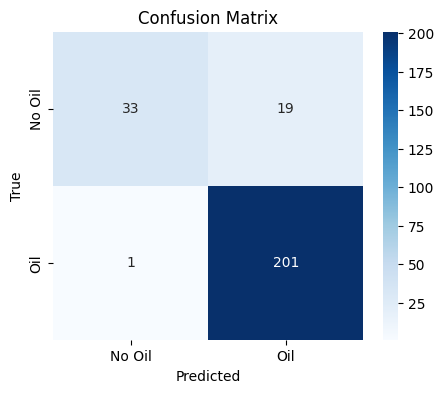

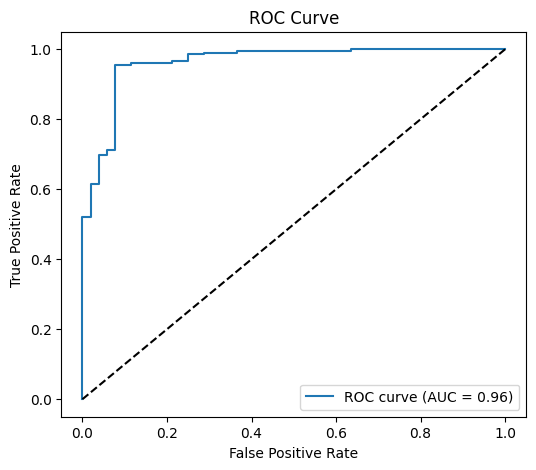

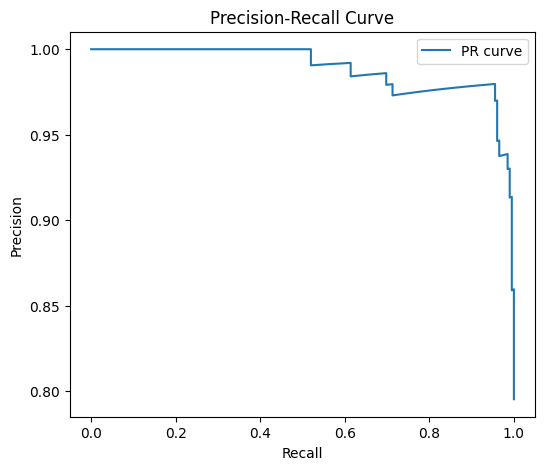

In [10]:
# Cell 9 - Evaluate on test set with confusion matrix, ROC, PR, and Grad-CAM

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns

# Step 1: Evaluate test set
test_loss, test_acc, test_auc = clf_model.evaluate(test_ds_clf)
print(f"\n✅ Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

# Step 2: Collect predictions
y_true = []
y_pred = []

for imgs, labels in test_ds_clf:
    preds = clf_model.predict(imgs)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred)

# Step 3: Confusion matrix
y_pred_classes = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Oil", "Oil"], yticklabels=["No Oil", "Oil"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Step 4: ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Step 5: Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


 Using last conv layer: conv2d_2
 Predicted class index: 0, probs: [[0.8638593]]
 CAM range: min=0.0000, max=0.9998


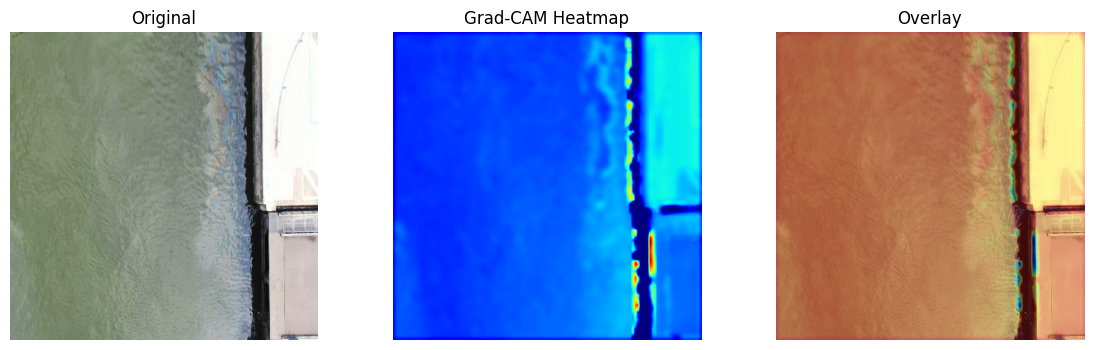

In [18]:

import cv2


def get_last_conv_layer(model):
    # Find the last conv layer in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError(" No Conv2D layer found in the model.")

def get_gradcam_heatmap(model, img_array, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer(model)
    print(f" Using last conv layer: {last_conv_layer_name}")

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Ensure tensor
    if isinstance(img_array, np.ndarray):
        img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        print(f" Predicted class index: {class_idx.numpy()}, probs: {predictions.numpy()}")
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    # Compute Grad-CAM
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)

    print(f" CAM range: min={cam.min():.4f}, max={cam.max():.4f}")
    return cam

# --- Visualization ---
for imgs, labels in test_ds_clf.take(1):
    sample_img = imgs[0:1]  # batch with 1 image
    cam = get_gradcam_heatmap(clf_model, sample_img)

    # Convert image for plotting
    img = sample_img[0].numpy()
    img = (img * 255).astype(np.uint8)

    # Resize CAM to match original image
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Plot results
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(cam_resized, cmap="jet"); plt.title("Grad-CAM Heatmap"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.show()
    break
